<a href="https://colab.research.google.com/github/vjuge/oc-iml/blob/vjuge%2Fissue13/modules/P7/module_P7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/vjuge/oc-iml/blob/vjuge%2Fissue13/modules/P7/module_P7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance
!pip install scalecast
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# NOTE : to be executed in Collab environment, since statsmodel needs to be updated

# !pip3 uninstall statsmodels
# !pip3 install numpy scipy patsy pandas
# !pip3 install statsmodels

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scalecast.Forecaster import Forecaster
from scalecast.auxmodels import auto_arima
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(20,10)})

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [3]:
!pip install yfinance
!pip install scalecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import json
import csv
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scalecast.Forecaster import Forecaster
from scalecast.auxmodels import auto_arima
from sklearn.model_selection import train_test_split
import tensorflow as tf
from datetime import datetime
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(30,10)})

import sys
import os

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
df_btc_usd = yf.download("BTC-USD")
df_btc_usd.shape
df_btc_usd.dtypes
df_btc_usd.columns
df_btc_usd.head()
df_btc_usd.index

df_btc_usd = df_btc_usd.asfreq('d')
pd.infer_freq(df_btc_usd.asfreq('d').index)


[*********************100%***********************]  1 of 1 completed


(2920, 6)

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


DatetimeIndex(['2014-09-17', '2014-09-18', '2014-09-19', '2014-09-20',
               '2014-09-21', '2014-09-22', '2014-09-23', '2014-09-24',
               '2014-09-25', '2014-09-26',
               ...
               '2022-09-05', '2022-09-06', '2022-09-07', '2022-09-08',
               '2022-09-09', '2022-09-10', '2022-09-11', '2022-09-12',
               '2022-09-13', '2022-09-14'],
              dtype='datetime64[ns]', name='Date', length=2920, freq=None)

'D'

In [6]:
# keep only CLose column
df_btc_usd = df_btc_usd['Close']
df_btc_usd = df_btc_usd[df_btc_usd.index > '2021-01-01']
df_btc_usd.shape


(621,)

### Naive Approach

In [7]:
f = Forecaster(y=df_btc_usd, current_dates=df_btc_usd.index)
f

Forecaster(
    DateStartActuals=2021-01-02T00:00:00.000000000
    DateEndActuals=2022-09-14T00:00:00.000000000
    Freq=D
    N_actuals=621
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
    GridsFile=Grids
)

In [8]:
f.generate_future_dates(12)
f.set_test_length(.2)
f.set_estimator('arima')
f.manual_forecast(call_me='arima1')

Text(0.5, 1.0, 'ARIMA Test-Set Performance')

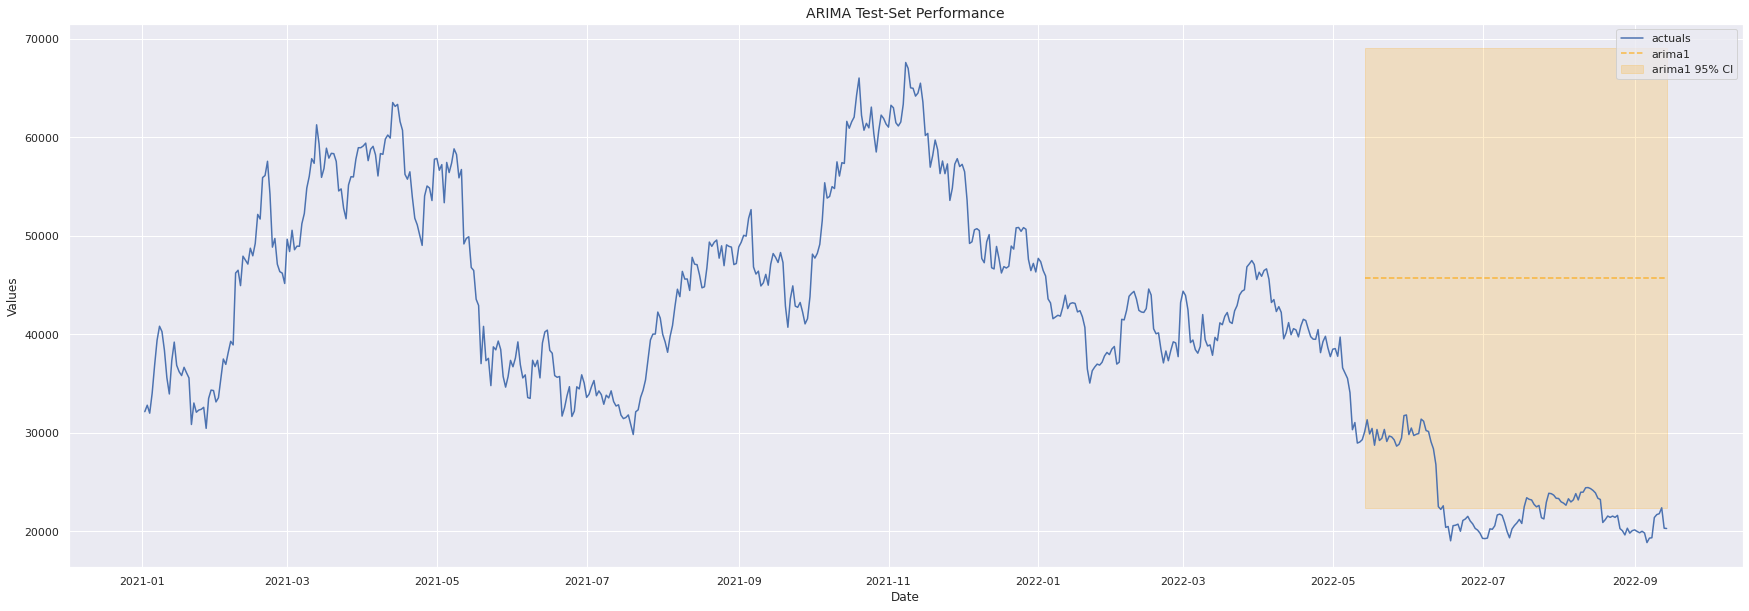

In [9]:
f.plot_test_set(ci=True)
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

Text(0.5, 1.0, 'ARIMA Forecast Performance')

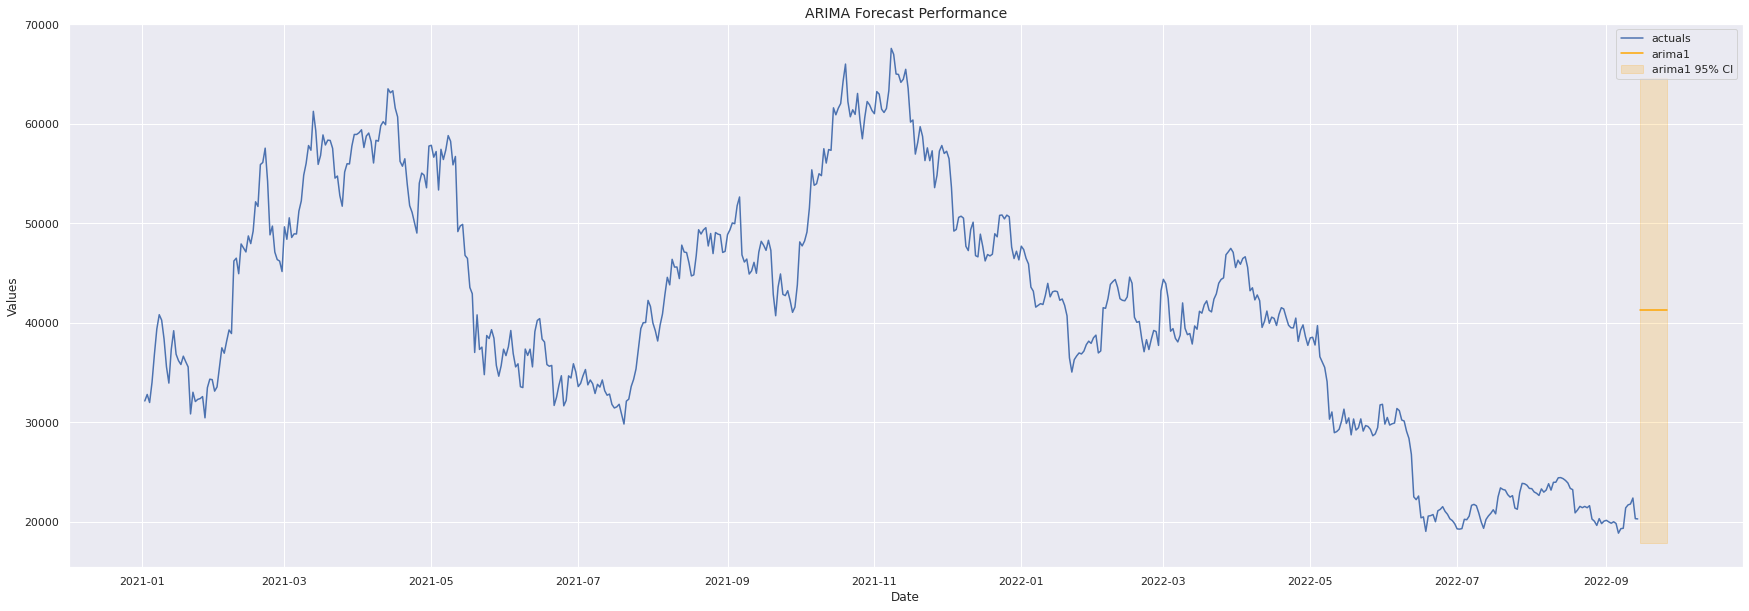

In [10]:
f.plot(ci=True)
plt.title('ARIMA Forecast Performance',size=14)
plt.show()

### Human Interpretation - Iterative Approach

Text(0.5, 1.0, 'ARIMA Test-Set Performance')

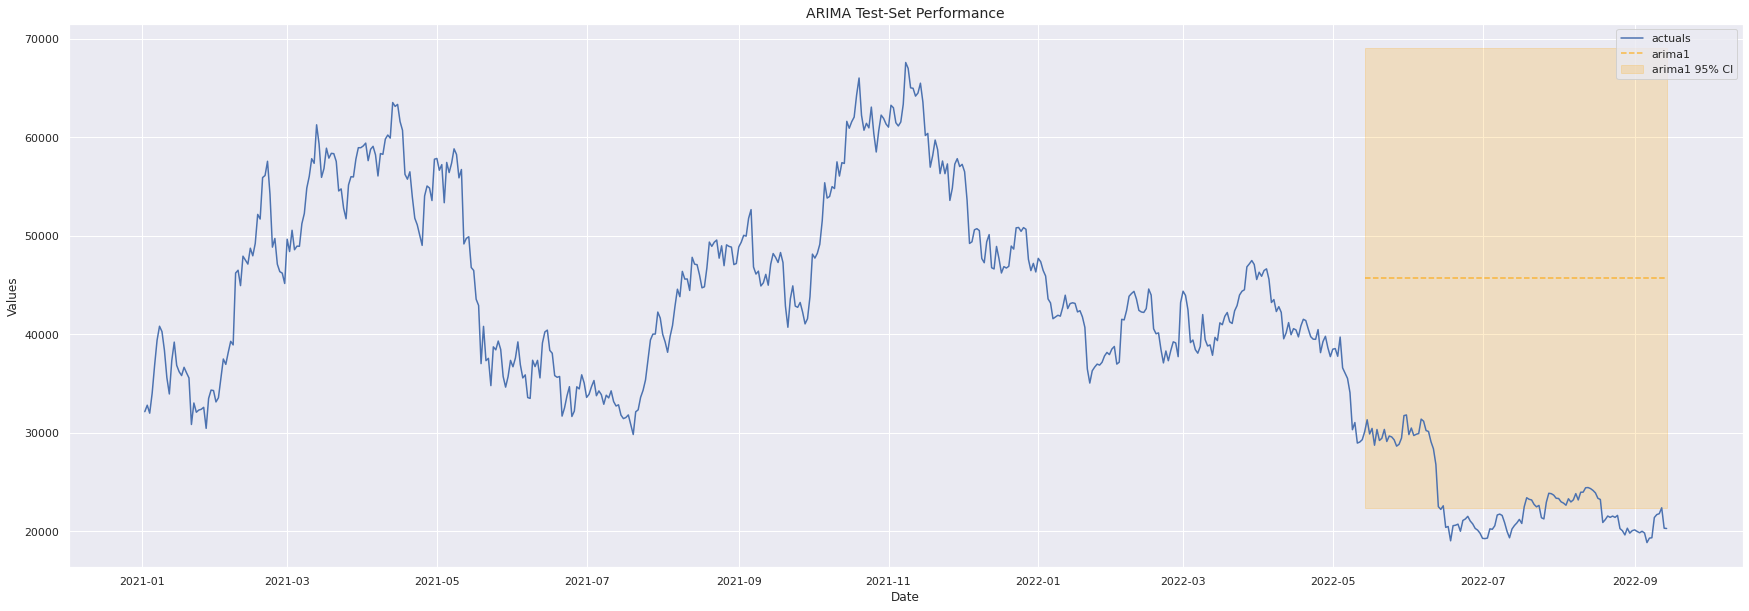

In [11]:
f.plot_test_set(ci=True)
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

Text(0.5, 1.0, 'ARIMA Forecast Performance')

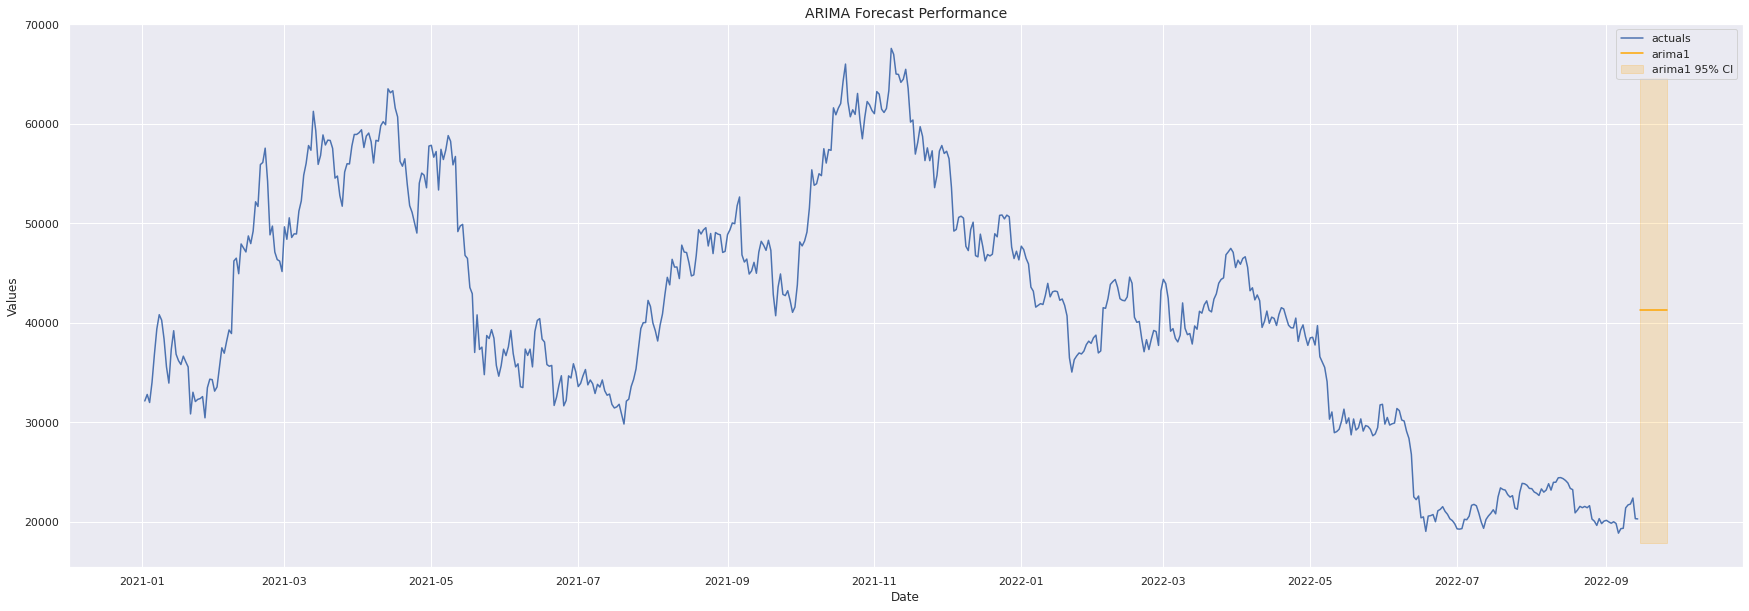

In [12]:
f.plot(ci=True)
plt.title('ARIMA Forecast Performance',size=14)
plt.show()

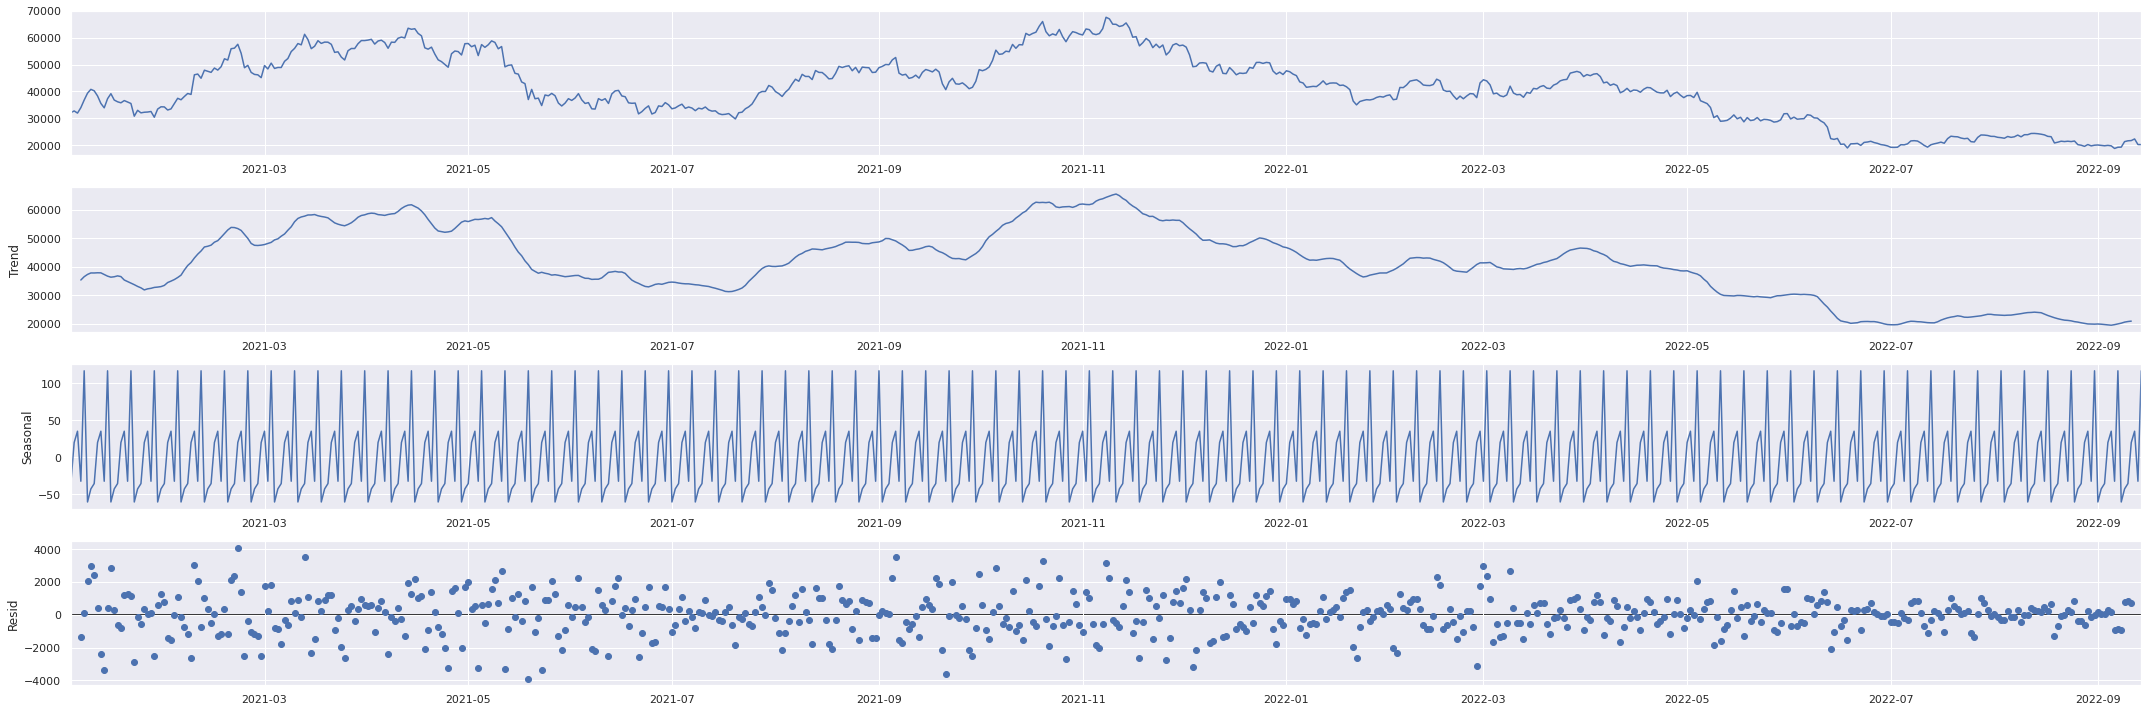

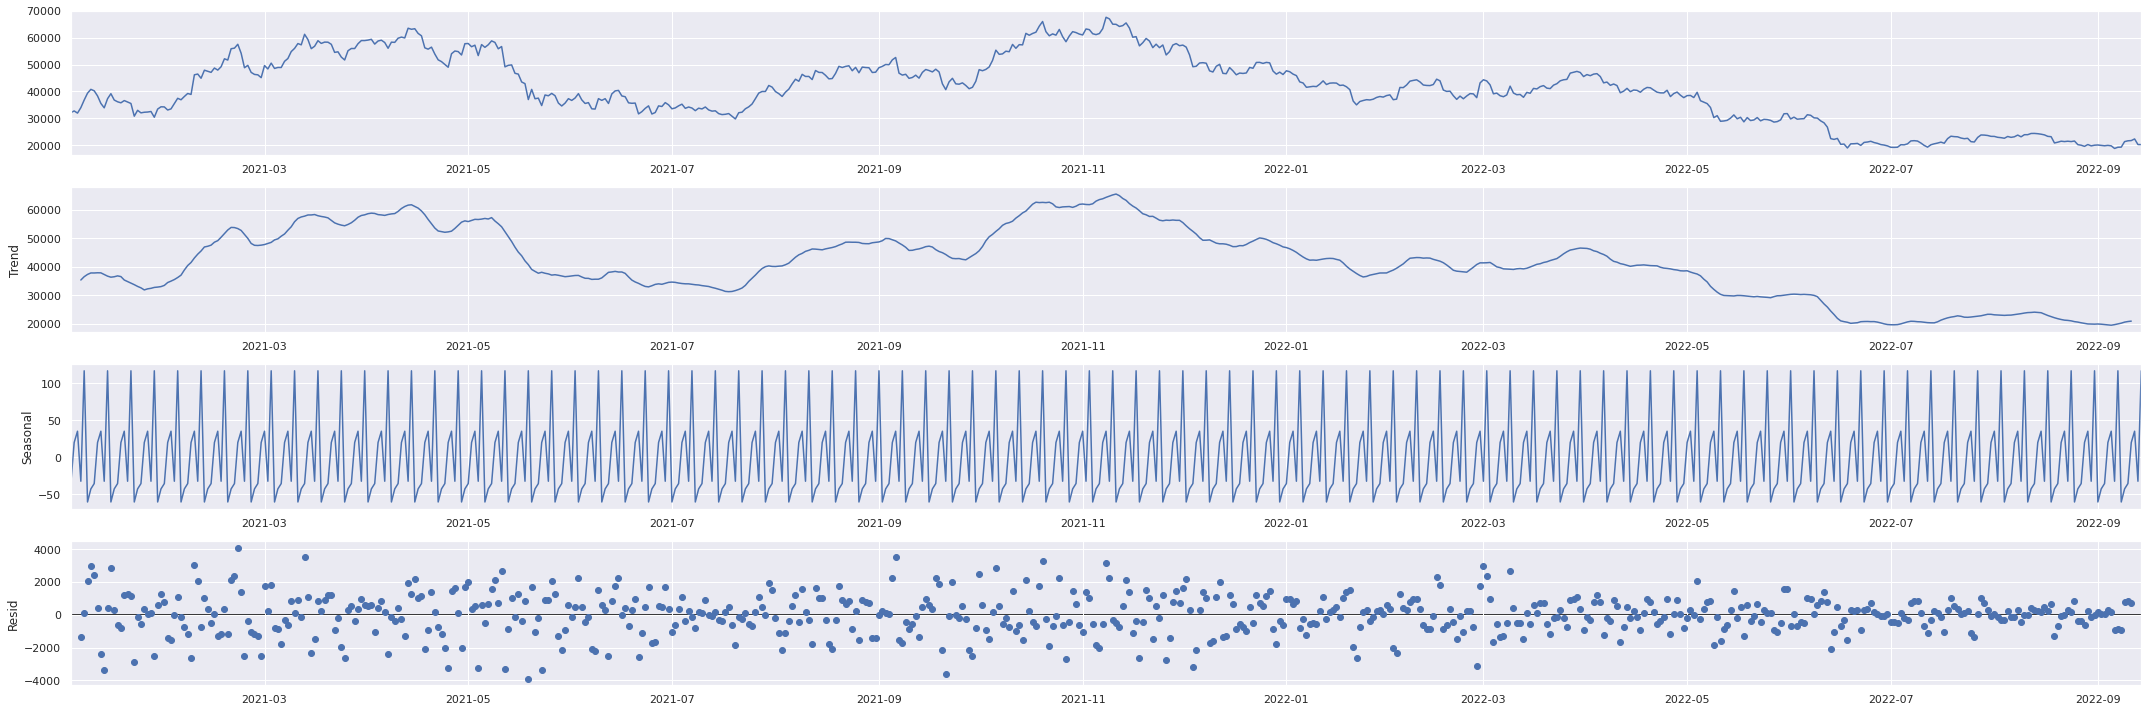

In [13]:
f.seasonal_decompose().plot()
plt.show()

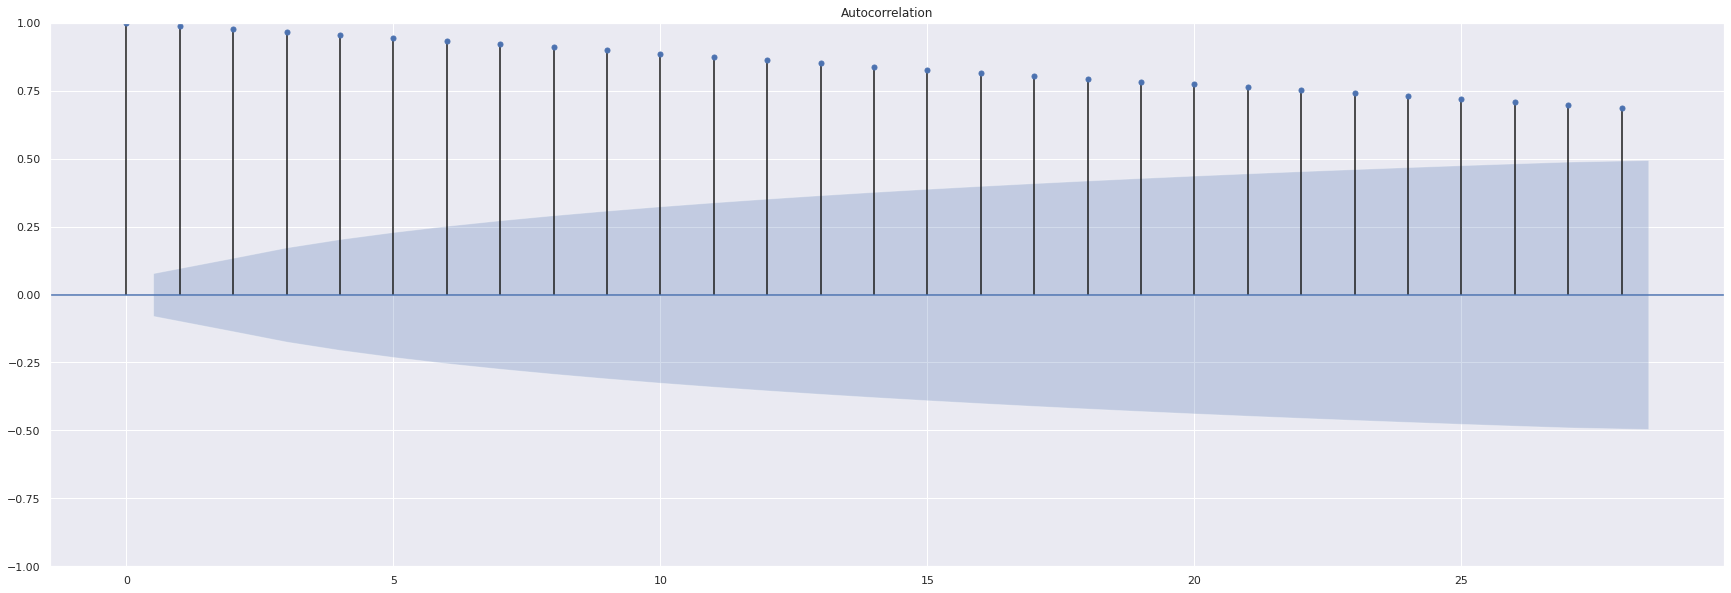

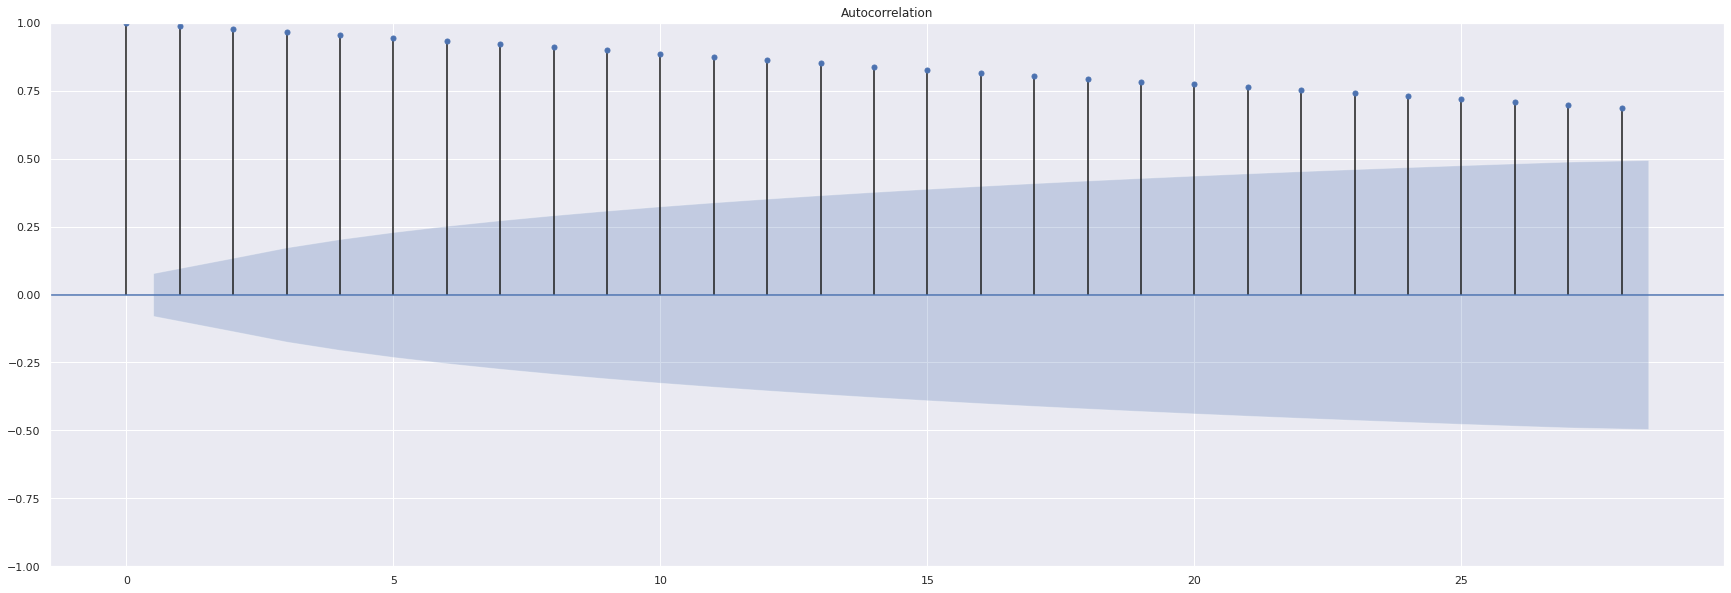

In [14]:
f.plot_acf()
plt.show()

In [15]:
f.manual_forecast(order=(1,1,1),seasonal_order=(2,1,1,12),call_me='arima2')


In [16]:
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print(stat)
print(pval)

-1.3247629375164114
0.6177684817099655


In [17]:
f.manual_forecast(order=(1,1,1),seasonal_order=(2,1,1,12),call_me='arima2')


Text(0.5, 1.0, 'ARIMA Test-Set Performance')

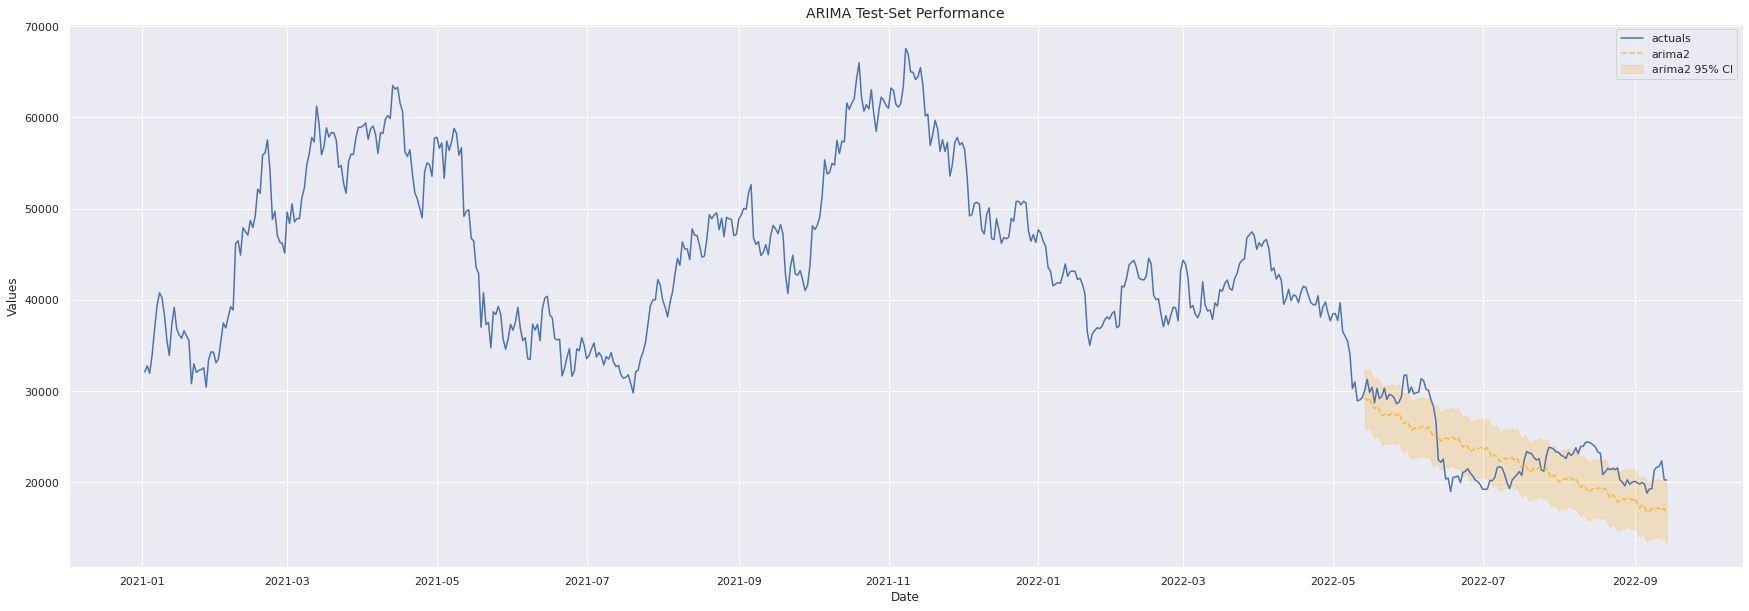

In [18]:
f.plot_test_set(ci=True,models='arima2')
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

Text(0.5, 1.0, 'ARIMA Forecast Performance')

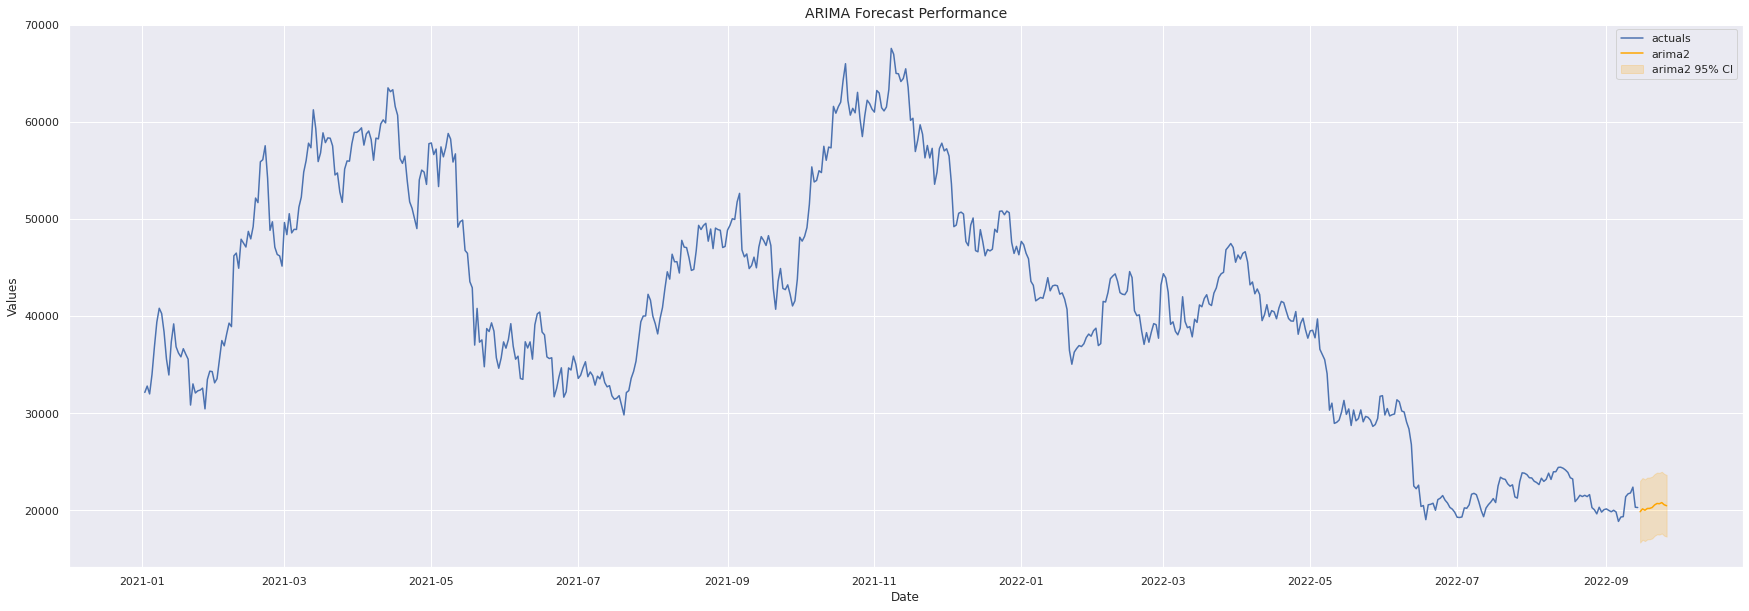

In [19]:
f.plot(ci=True,models='arima2')
plt.title('ARIMA Forecast Performance',size=14)
plt.show()

In [20]:
f.regr.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                                y   No. Observations:                  621
Model:             ARIMA(1, 1, 1)x(2, 1, 1, 12)   Log Likelihood               -5435.656
Date:                          Wed, 14 Sep 2022   AIC                          10883.312
Time:                                  14:58:32   BIC                          10909.773
Sample:                                       0   HQIC                         10893.607
                                          - 621                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.118      8.445      0.000       0.768       1.232
ma.L1         -0.9999      0.344     -2.905      0.004      -1.675      -0.325
ar.S.L12       0.1148      0.037      3.142      0.002       0.043       0.186
ar.S.L24       0.0706      0.026      2.692      0.007       0.019       0.122
ma.S.L12      -0.9978      0.425     -2.347      0.019      -1.831      -0.165
sigma2      4.052e+06   1.15e-07   3.52e+13      0.000    4.05e+06    4.05e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.69   Jarque-Bera (JB):               280.28
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               0.26   Skew:                            -0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.8e+29. Standard errors may be unstable.
"""

## Auto ARIMA Approach

In [22]:
auto_arima(
    f,
    start_P=1,
    start_q=1,
    max_p=6,
    max_q=6,
    m=12,
    seasonal=True,
    max_P=2,
    max_D=2,
    max_Q=2,
    max_d=2,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    information_criterion="aic",
    alpha=0.05,
    scoring='mse',
    call_me='arima3',
)

Performing stepwise search to minimize aic
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=8840.181, Time=1.24 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8835.313, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8837.784, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=8837.926, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8833.319, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=8836.057, Time=0.16 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=8836.203, Time=0.14 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=8834.549, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=8837.045, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=8837.043, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=8839.037, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 2.610 seconds


Text(0.5, 1.0, 'ARIMA Test-Set Performance')

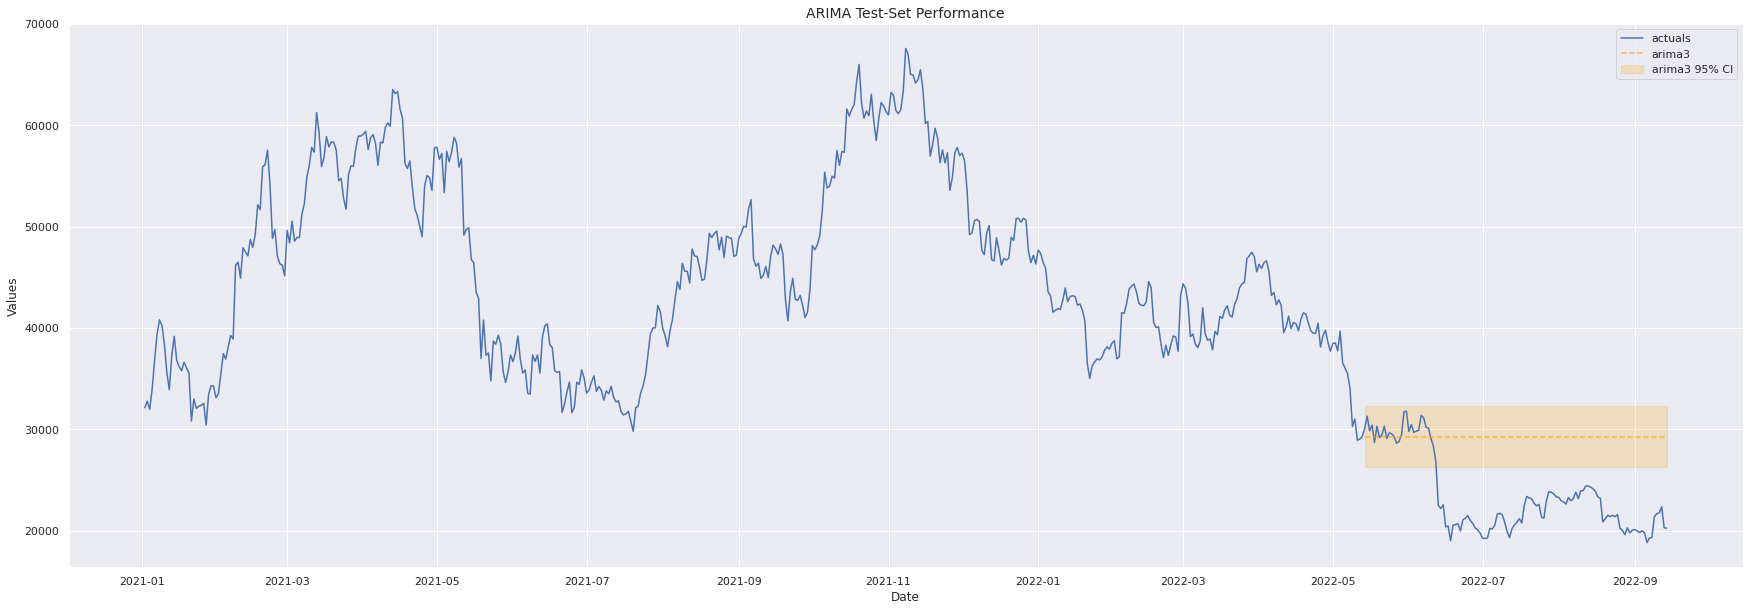

In [23]:
f.plot_test_set(ci=True,models='arima3')
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

Text(0.5, 1.0, 'ARIMA Forecast Performance')

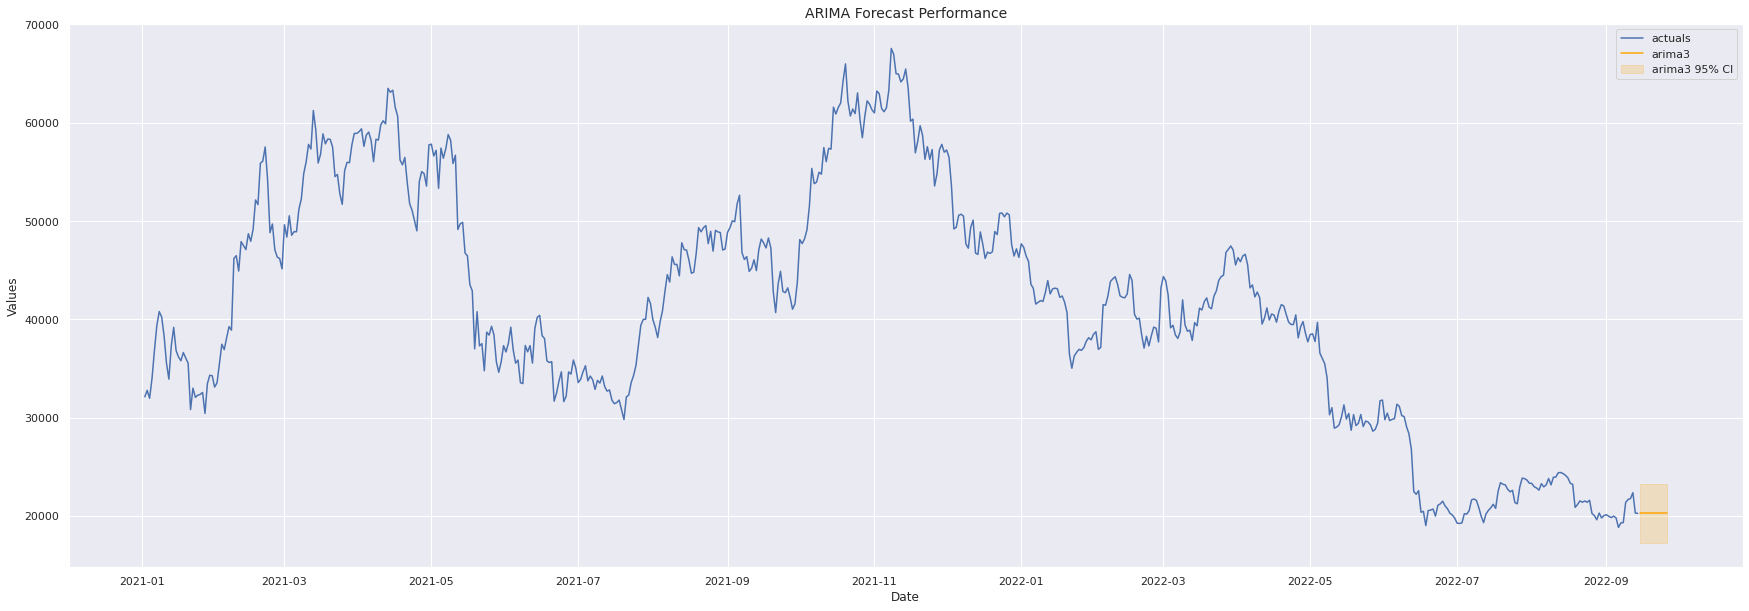

In [24]:
f.plot(ci=True,models='arima3')
plt.title('ARIMA Forecast Performance',size=14)
plt.show()

In [25]:
f.regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  621
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -5469.381
Date:                Wed, 14 Sep 2022   AIC                          10940.762
Time:                        14:58:36   BIC                          10945.192
Sample:                             0   HQIC                         10942.484
                                - 621                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.686e+06   1.05e+05     25.659      0.000    2.48e+06    2.89e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.82   Jarque-Bera (JB):               129.40
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):               0.32   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Grid Search Approach - TODO

## LSTM

In [26]:
critical_pval = 0.05
print('-'*100)
print('Augmented Dickey-Fuller results:')
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print('the test-stat value is: {:.2f}'.format(stat))
print('the p-value is {:.4f}'.format(pval))
print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
print('-'*100)

----------------------------------------------------------------------------------------------------
Augmented Dickey-Fuller results:
the test-stat value is: -1.32
the p-value is 0.6178
the series is not stationary
----------------------------------------------------------------------------------------------------


### Prepare Forecast for LSTM

In [27]:
f.set_test_length(12)
f.generate_future_dates(12)

#### Attempt 1

In [28]:
f.set_estimator('lstm')
f.manual_forecast(call_me='lstm_default')

19/19 [==============================] - 1s 3ms/step - loss: 0.4439


Text(0.5, 1.0, 'Default Test-set Performance')

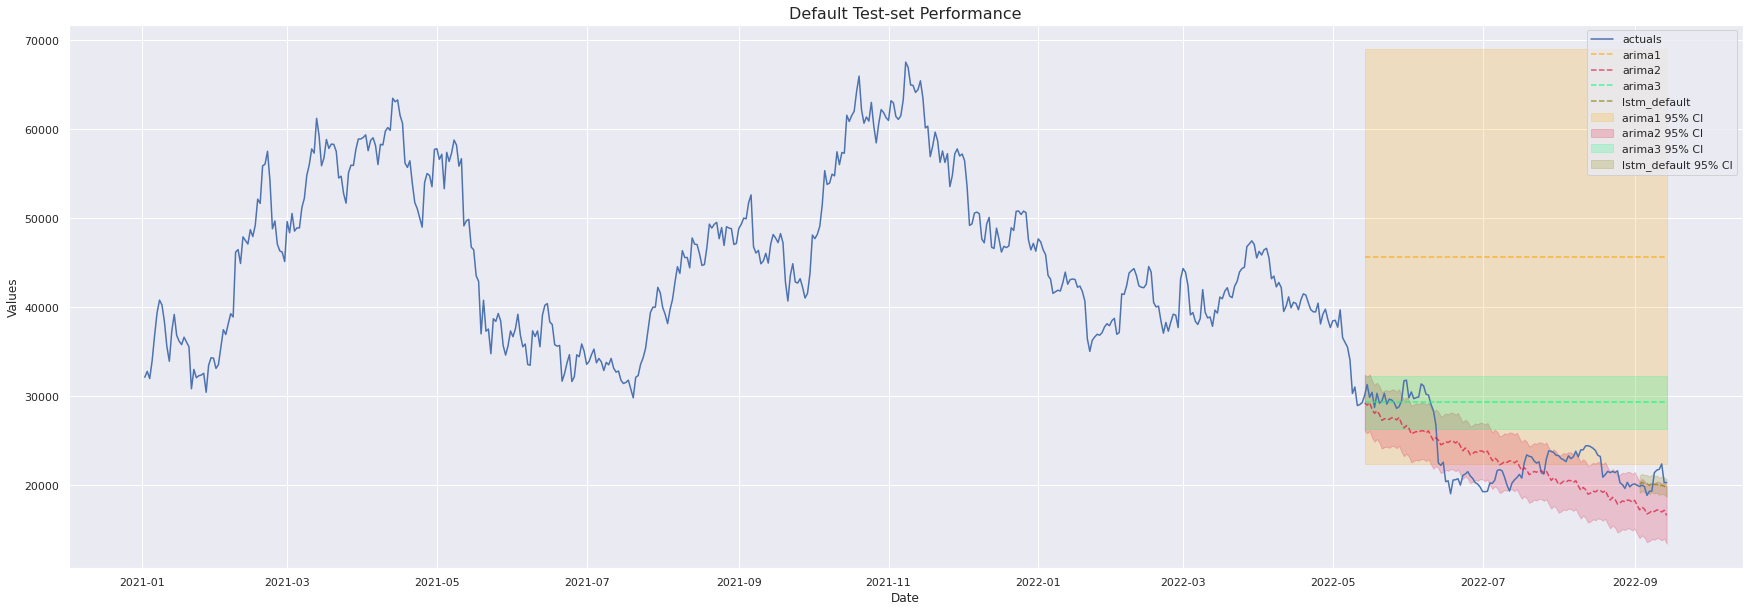

In [29]:
f.plot_test_set(ci=True)
plt.title('Default Test-set Performance',size=16)
plt.show()

#### Attempt 2

In [30]:
f.manual_forecast(call_me='lstm_24lags',lags=24)

19/19 [==============================] - 2s 4ms/step - loss: 0.4392


Text(0.5, 1.0, 'All Models Test-set Performance')

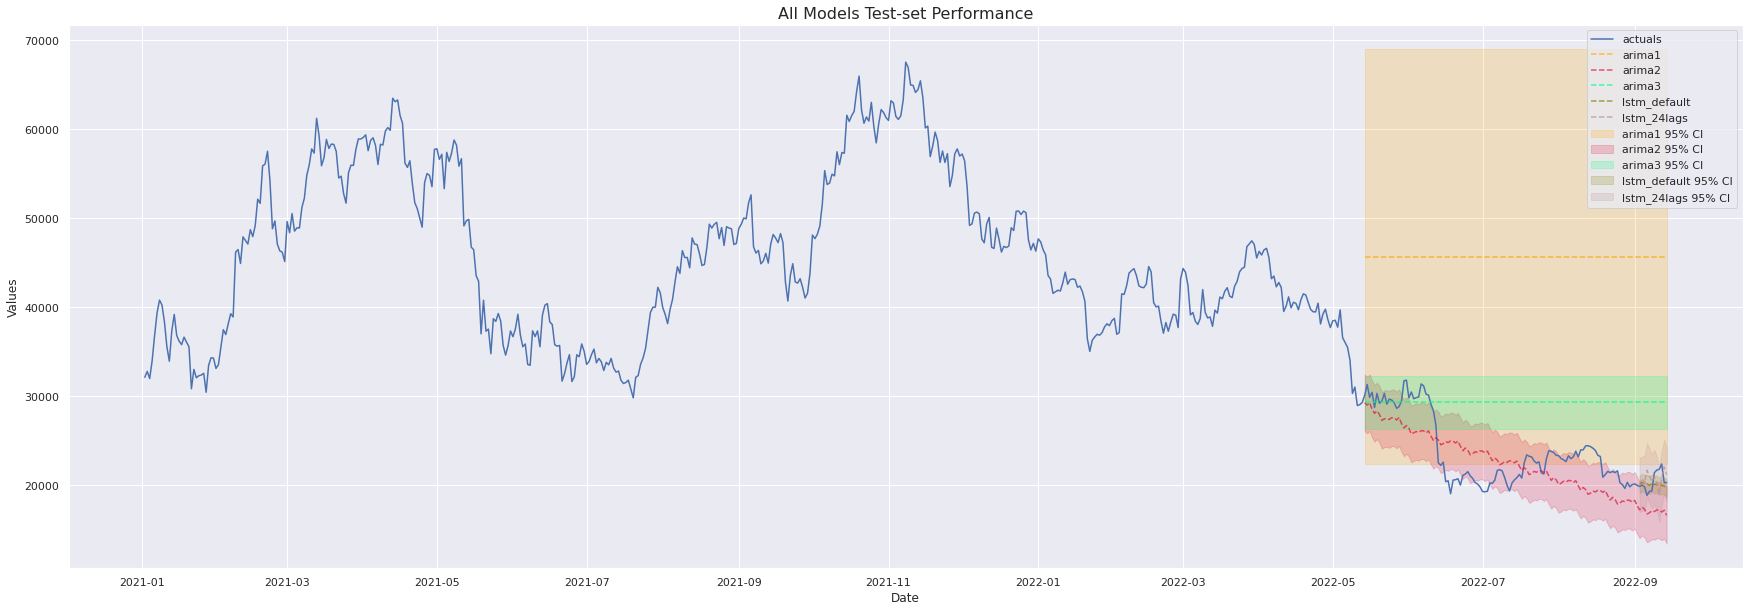

In [31]:
f.plot_test_set(ci=True)
plt.title('All Models Test-set Performance',size=16)
plt.show()

#### Attempt 3

In [32]:
f.manual_forecast(call_me='lstm_24lags_5epochs',lags=24,epochs=5,validation_split=.2,shuffle=True)


Epoch 1/5
15/15 [==============================] - 2s 36ms/step - loss: 0.4199 - val_loss: 0.6487
Epoch 2/5
15/15 [==============================] - 0s 6ms/step - loss: 0.3858 - val_loss: 0.6057
Epoch 3/5
15/15 [==============================] - 0s 6ms/step - loss: 0.3526 - val_loss: 0.5563
Epoch 4/5
15/15 [==============================] - 0s 6ms/step - loss: 0.3142 - val_loss: 0.4908
Epoch 5/5
15/15 [==============================] - 0s 6ms/step - loss: 0.2722 - val_loss: 0.4171
Epoch 1/5
15/15 [==============================] - 2s 35ms/step - loss: 0.3861 - val_loss: 0.5934
Epoch 2/5
15/15 [==============================] - 0s 6ms/step - loss: 0.3334 - val_loss: 0.5175
Epoch 3/5
15/15 [==============================] - 0s 6ms/step - loss: 0.2769 - val_loss: 0.4218
Epoch 4/5
15/15 [==============================] - 0s 6ms/step - loss: 0.2244 - val_loss: 0.3260
Epoch 5/5
15/15 [==============================] - 0s 6ms/step - loss: 0.1836 - val_loss: 0.2732


Text(0.5, 1.0, 'All Models Test-set Performance')

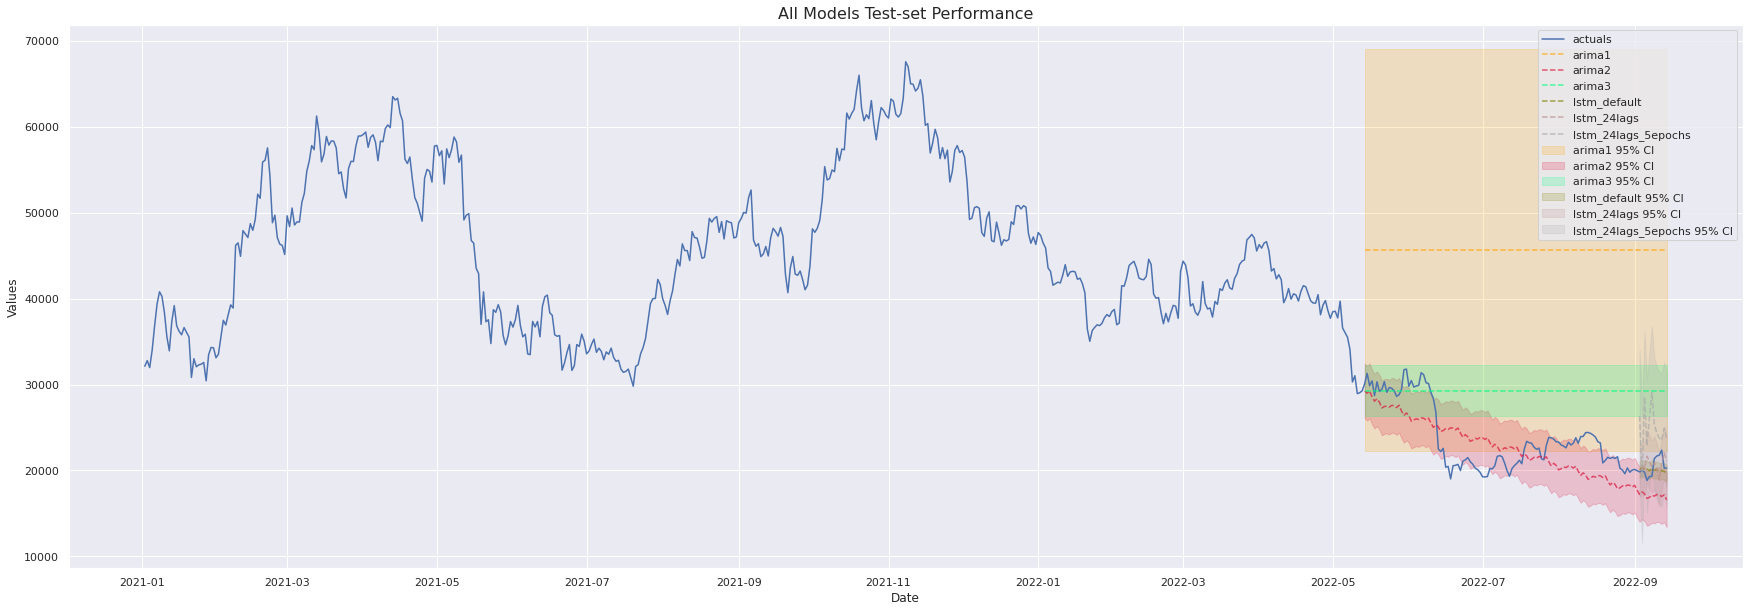

In [33]:
f.plot_test_set(ci=True)
plt.title('All Models Test-set Performance',size=16)
plt.show()

#### Attempt 4

In [34]:
from tensorflow.keras.callbacks import EarlyStopping
f.manual_forecast(call_me='lstm_24lags_earlystop_3layers',
                  lags=24,
                  epochs=25,
                  validation_split=.2,
                  shuffle=True,
                  callbacks=EarlyStopping(monitor='val_loss',
                                          patience=5),
                  lstm_layer_sizes=(16,16,16),
                  dropout=(0,0,0))

Epoch 1/25
15/15 [==============================] - 6s 85ms/step - loss: 0.3924 - val_loss: 0.5538
Epoch 2/25
15/15 [==============================] - 0s 9ms/step - loss: 0.3003 - val_loss: 0.4037
Epoch 3/25
15/15 [==============================] - 0s 9ms/step - loss: 0.1947 - val_loss: 0.2431
Epoch 4/25
15/15 [==============================] - 0s 9ms/step - loss: 0.1204 - val_loss: 0.1737
Epoch 5/25
15/15 [==============================] - 0s 9ms/step - loss: 0.1015 - val_loss: 0.1585
Epoch 6/25
15/15 [==============================] - 0s 9ms/step - loss: 0.0944 - val_loss: 0.1760
Epoch 7/25
15/15 [==============================] - 0s 10ms/step - loss: 0.0899 - val_loss: 0.1621
Epoch 8/25
15/15 [==============================] - 0s 10ms/step - loss: 0.0871 - val_loss: 0.1464
Epoch 9/25
15/15 [==============================] - 0s 10ms/step - loss: 0.0844 - val_loss: 0.1582
Epoch 10/25
15/15 [==============================] - 0s 10ms/step - loss: 0.0842 - val_loss: 0.1351
Epoch 11/25
15

Text(0.5, 1.0, 'All Models Test-Set Performance')

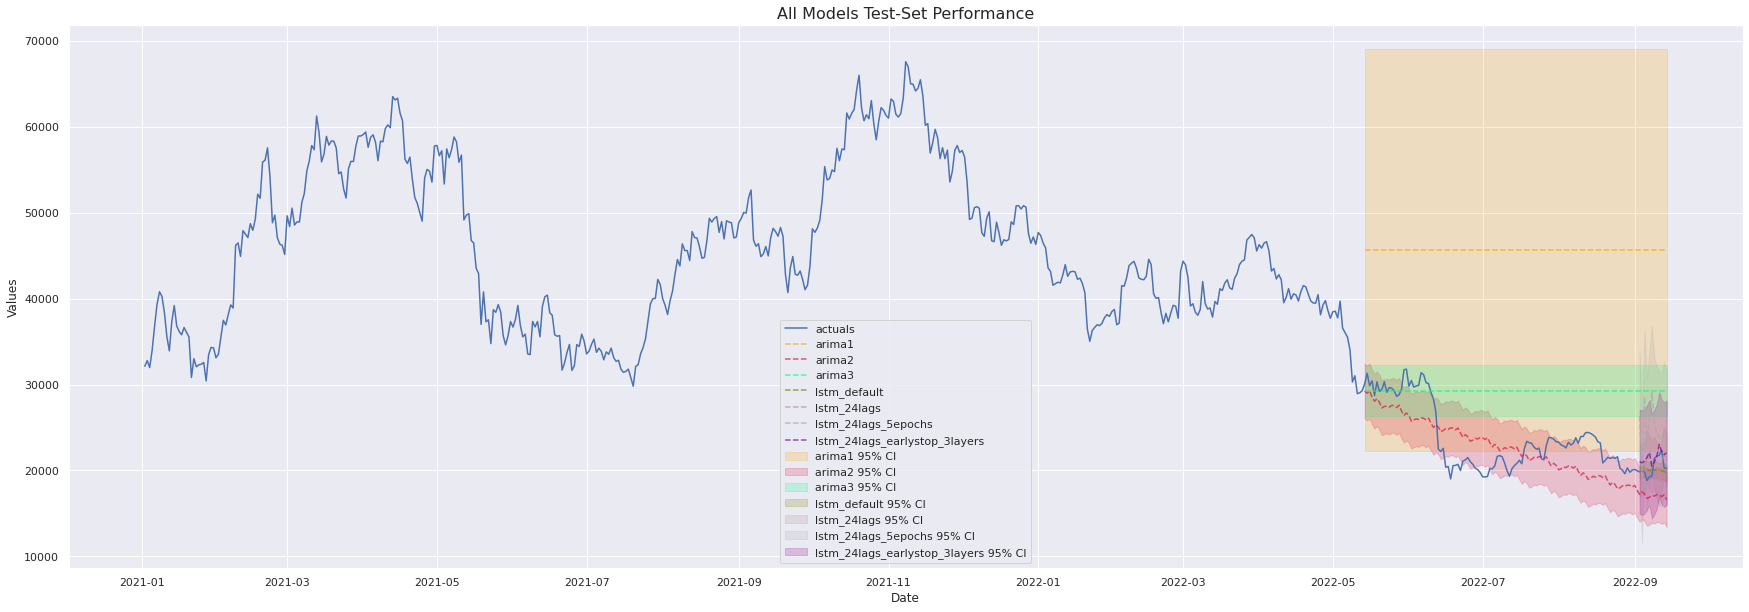

In [35]:
f.plot_test_set(ci=True)
plt.title('All Models Test-Set Performance',size=16)
plt.show()

#### Attempt 5

Epoch 1/15
14/14 [==============================] - 7s 160ms/step - loss: 0.2422 - val_loss: 0.2220
Epoch 2/15
14/14 [==============================] - 0s 16ms/step - loss: 0.1114 - val_loss: 0.1780
Epoch 3/15
14/14 [==============================] - 0s 13ms/step - loss: 0.0956 - val_loss: 0.1588
Epoch 4/15
14/14 [==============================] - 0s 13ms/step - loss: 0.0895 - val_loss: 0.1650
Epoch 5/15
14/14 [==============================] - 0s 13ms/step - loss: 0.0827 - val_loss: 0.1273
Epoch 6/15
14/14 [==============================] - 0s 13ms/step - loss: 0.0803 - val_loss: 0.1269
Epoch 7/15
14/14 [==============================] - 0s 13ms/step - loss: 0.0781 - val_loss: 0.1408
Epoch 8/15
14/14 [==============================] - 0s 13ms/step - loss: 0.0771 - val_loss: 0.1351
Epoch 9/15
14/14 [==============================] - 0s 14ms/step - loss: 0.0775 - val_loss: 0.1306
Epoch 10/15
14/14 [==============================] - 0s 13ms/step - loss: 0.0798 - val_loss: 0.1286
Epoch 11

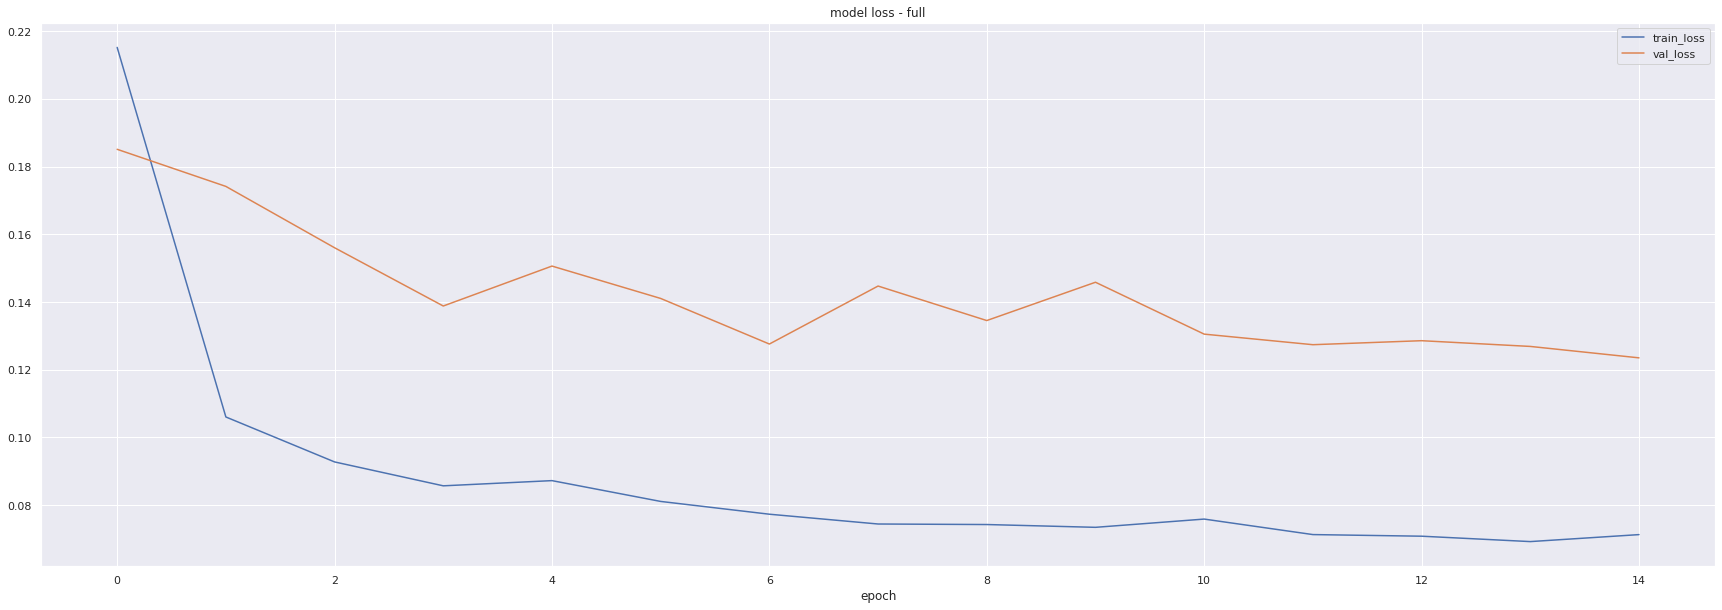

In [36]:
f.manual_forecast(call_me='lstm_24lags_4layers_15epochs',
                  lags=36,
                  batch_size=32,
                  epochs=15,
                  validation_split=.2,
                  shuffle=True,
                  activation='tanh',
                  optimizer='Adam',
                  learning_rate=0.001,
                  lstm_layer_sizes=(72,)*4,
                  dropout=(0,)*4,
                  plot_loss=True)

Text(0.5, 1.0, '24 Lags 4 Layers 15 Epochs Test-Set Performance')

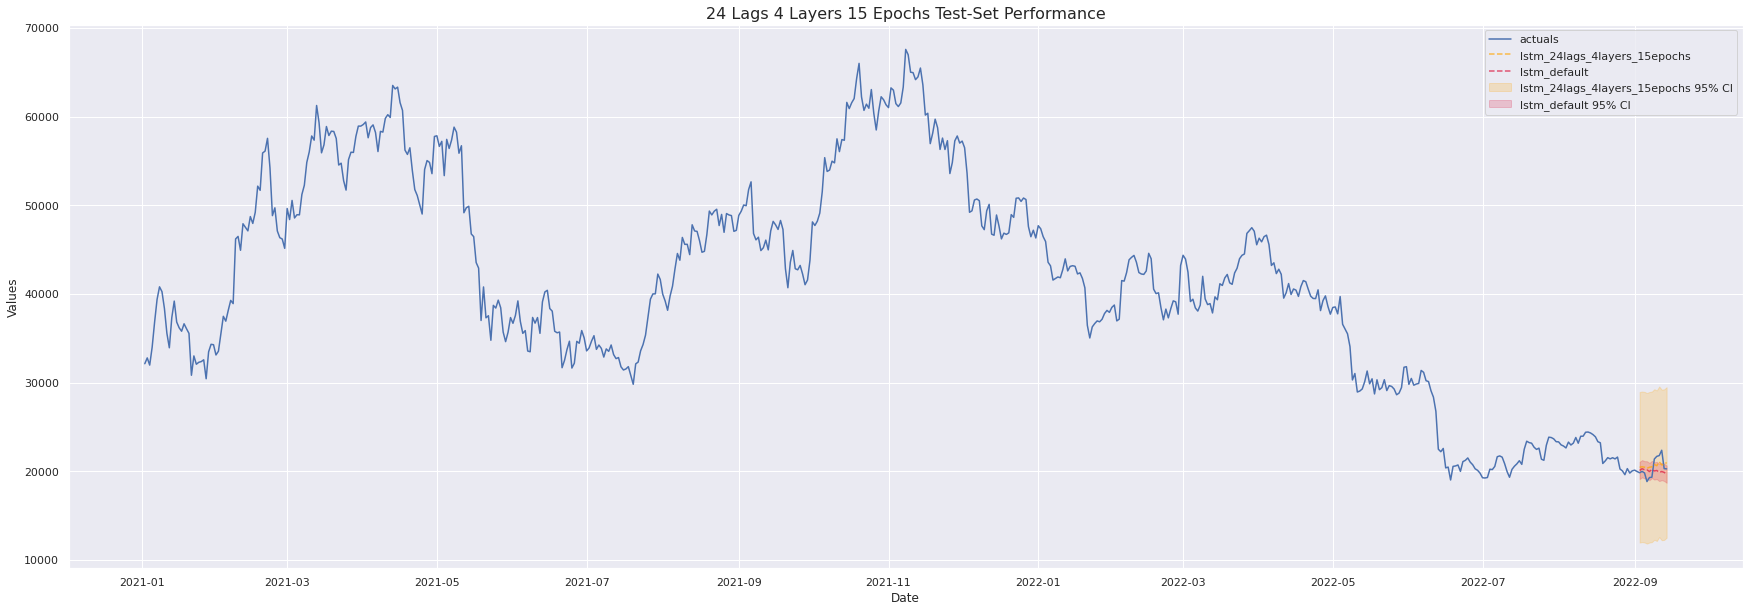

In [37]:
f.plot_test_set(order_by='LevelTestSetMAPE',models='top_2',ci=True)
plt.title('24 Lags 4 Layers 15 Epochs Test-Set Performance',size=16)
plt.show()

#### Attempt 6

Epoch 1/300
28/28 [==============================] - 24s 248ms/step - loss: 0.2358 - val_loss: 0.2767
Epoch 2/300
28/28 [==============================] - 1s 50ms/step - loss: 0.1455 - val_loss: 0.2191
Epoch 3/300
28/28 [==============================] - 1s 49ms/step - loss: 0.1494 - val_loss: 0.2866
Epoch 4/300
28/28 [==============================] - 1s 49ms/step - loss: 0.1395 - val_loss: 0.2441
Epoch 5/300
28/28 [==============================] - 1s 49ms/step - loss: 0.1399 - val_loss: 0.2233
Epoch 6/300
28/28 [==============================] - 1s 50ms/step - loss: 0.1416 - val_loss: 0.2258
Epoch 7/300
28/28 [==============================] - 1s 50ms/step - loss: 0.1377 - val_loss: 0.2432
Epoch 8/300
28/28 [==============================] - 1s 49ms/step - loss: 0.1404 - val_loss: 0.2397
Epoch 9/300
28/28 [==============================] - 1s 50ms/step - loss: 0.1370 - val_loss: 0.2158
Epoch 10/300
28/28 [==============================] - 1s 49ms/step - loss: 0.1338 - val_loss: 0.23

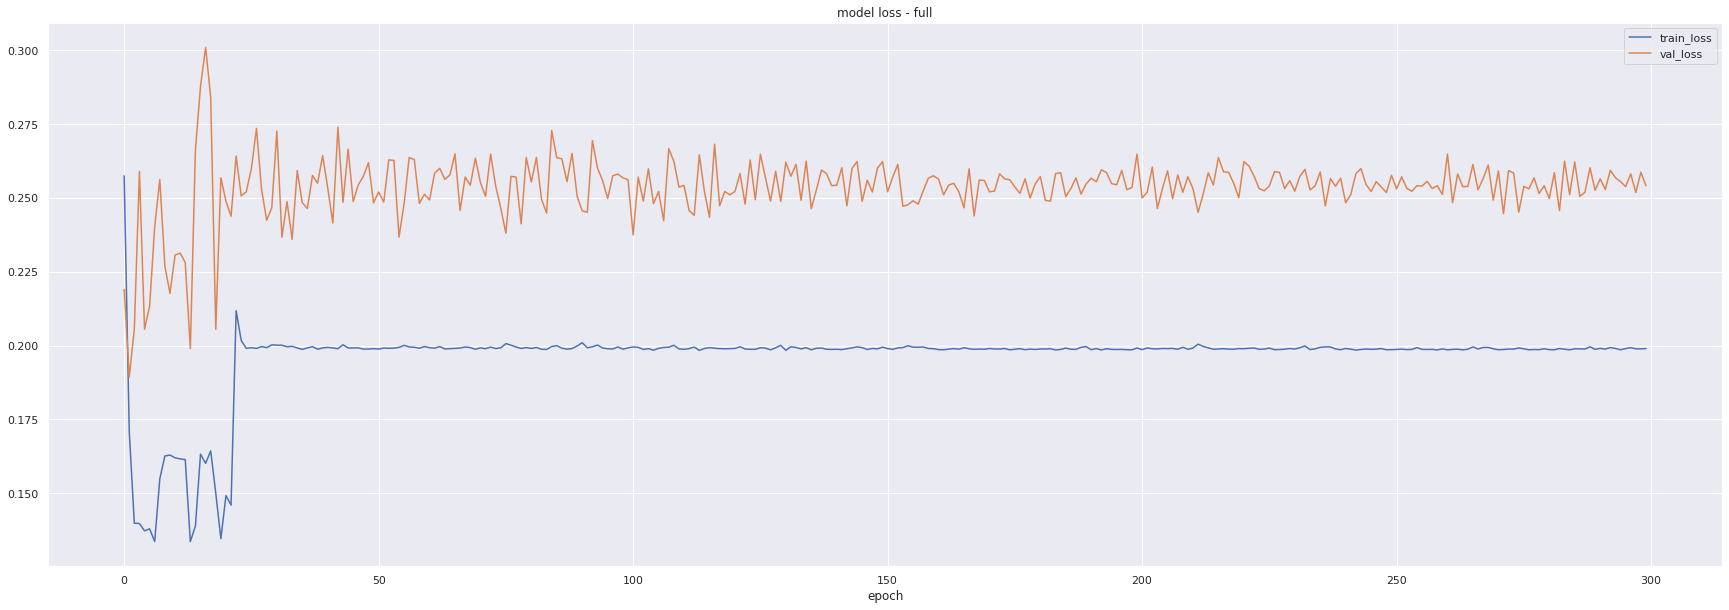

In [38]:
f.manual_forecast(call_me='lstm_best',
                  lags=36,
                  batch_size=16,
                  epochs=300,
                  validation_split=.2,
                  shuffle=True,
                  activation='tanh',
                  optimizer='Adam',
                  learning_rate=0.001,
                  lstm_layer_sizes=(100,)*15,
                  dropout=(0,)*15,
                  plot_loss=True)

Text(0.5, 1.0, 'Top-2 Models Test-set Performance')

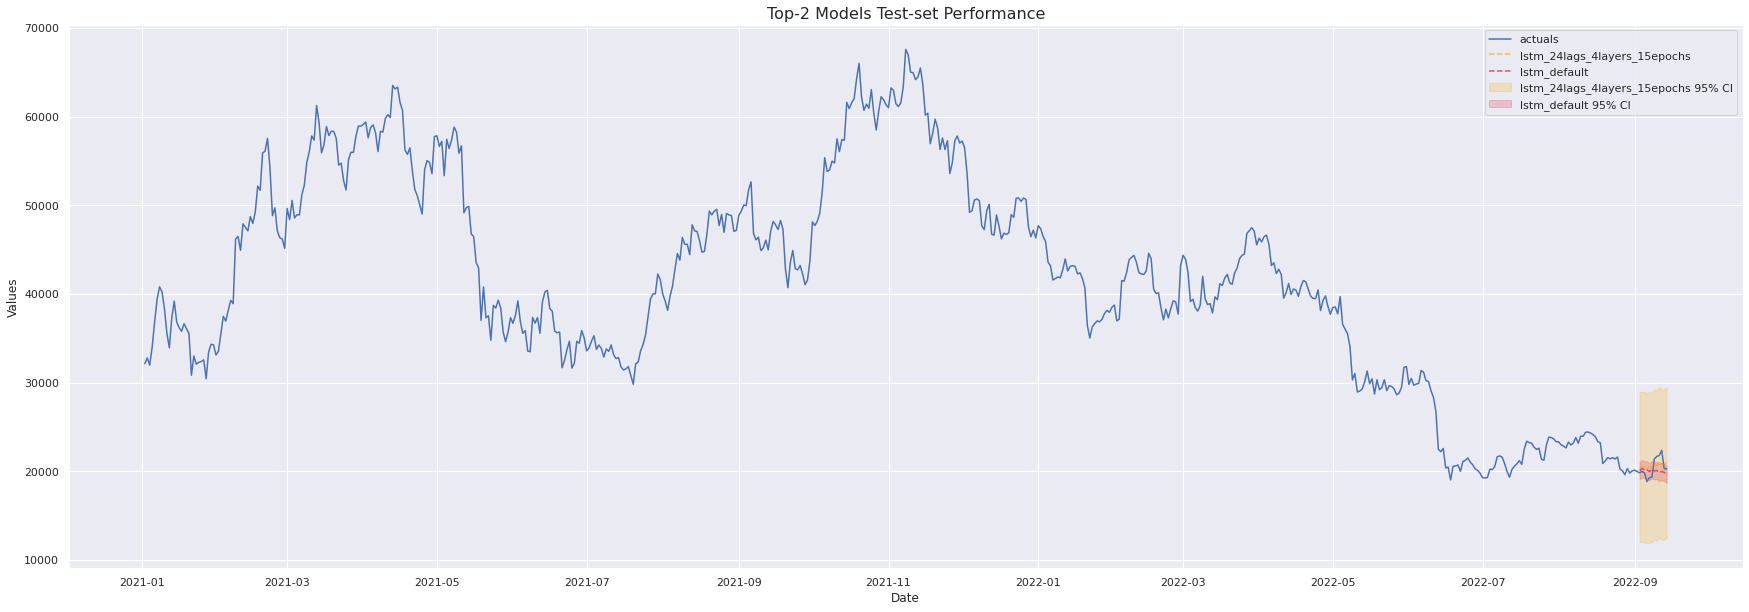

In [39]:
f.plot_test_set(order_by='LevelTestSetMAPE',models='top_2',ci=True)
plt.title('Top-2 Models Test-set Performance',size=16)
plt.show()